# Hydrometeorological time series

Notebook to create a .csv file with the hydrometeorological time series data for all CAMELS-DE catchments.  

Variables:
- q
- w
- precipitation

In [1]:
import os

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from camelsp import get_metadata, Station
from camelsp.util import OUTPUT_PATH

/home/alexd/miniconda3/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Create folder structure

Inspired by CAMELS-UK

In [2]:
# create folder camels_de
os.makedirs("../output_data/camels_de", exist_ok=True)

# create subfolder CAMELS_DE_catchment_boundaries and timeseries
os.makedirs("../output_data/camels_de/timeseries", exist_ok=True)

## Make selection of stations

- At least 10 years of discharge data **-> we have to controll this again after trimming the data to 1951-2021**
- MERIT Hydro catchment geometry available
- catchment area greater than 5 km² and smaller than 15000 km²
- catchment area located entirely within Germany
- catchment area max difference to reported area 10 percent
- all HYRAS variables available 

### Preselection criteria from metadata

In [3]:
# get metadata
metadata = get_metadata()

# preselect stations
metadata = metadata[
    (metadata["q_more_than_10_years"]) &
    (metadata["merit_hydro_available"] == True) &
    (metadata["merit_area_greater_5_smaller_15000"] == True) &
    (metadata["merit_completely_within_germany"] == True) &
    (metadata["merit_difference_to_reported_area_smaller_10_percent"] == True)
    ]

print(f"Number of stations after preselection: {len(metadata)}")

Number of stations after preselection: 1483


### HYRAS availability

In [4]:
# check availability of all HYRAS variables
hyras_available = pd.read_csv(os.path.join(OUTPUT_PATH, "scripts/meteo/hyras/hyras_exact_extract_availability.csv"), index_col=0)

# check where all columns are True
hyras_available = hyras_available.all(axis="columns")

# only keep stations where all columns are True
hyras_available = hyras_available[hyras_available]

# compare with metadata
metadata = metadata[metadata["camels_id"].isin(hyras_available.index)]

print(f"Number of stations after HYRAS availability check: {len(metadata)}")

Number of stations after HYRAS availability check: 1465


### Check Q > 10 years after trimming to 1951-2020

In [5]:
# set threshold for minimum number of days / data points
threshold = 365*10

q_more_than_10_years = []

for camels_id in metadata["camels_id"]:
    # initialize station
    s = Station(camels_id)

    # get data
    df = s.get_data(date_index=False)

    # trim to start and end date
    start_date, end_date = "1951-01-01", "2020-12-31"
    df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

    # count q values that are not nan
    if 'q' in df.columns:
        q_count = df['q'].count()

        if q_count > threshold:
            q_more_than_10_years.append(camels_id)

# compare with metadata
metadata = metadata[metadata["camels_id"].isin(q_more_than_10_years)]

print(f"Number of stations after threshold check: {len(q_more_than_10_years)}")

Number of stations after threshold check: 1460


In [6]:
camels_ids = metadata["camels_id"]

print(f"Total number of stations in CAMELS-DE v1: {len(camels_ids)}")

Total number of stations in CAMELS-DE v1: 1460


## Merge HYRAS with q/w data and save as .csv

For some stations, there are duplicated dates in the q/w data. We will remove these duplicates by taking the mean of the duplicates if the difference of the max and min q/w values to the mean q v/w value is smaller than 0.05.

In [7]:
def average_out_duplicated_dates(df_qw: pd.DataFrame) -> pd.DataFrame:
    """
    Helper function to average out duplicated dates in a DataFrame with columns 
    "date", "q" and "w".
    Averaging only happens if thev relative difference of the max and min value 
    of q and w to the mean value is smaller than 0.05. Otherwise, a ValueError 
    is raised.

    Parameters
    ----------
    df_qw : pd.DataFrame
        DataFrame with columns "date", "q" and "w".
    
    Returns
    -------
    pd.DataFrame
        DataFrame with averaged out duplicated dates.

    """
    # get duplicated dates
    duplicated_dates = df_qw[df_qw["date"].duplicated()]["date"].unique()

    # loop over duplicated dates, if duplicates are within 0.05 of each other, take the mean to remove duplicates
    for duplicated_date in duplicated_dates:
        # get min, max and mean of q for duplicated date
        min_q = df_qw[df_qw["date"] == duplicated_date]["q"].min()
        max_q = df_qw[df_qw["date"] == duplicated_date]["q"].max()
        mean_q = df_qw[df_qw["date"] == duplicated_date]["q"].mean()

        # get min, max and mean of w for duplicated date
        min_w = df_qw[df_qw["date"] == duplicated_date]["w"].min()
        max_w = df_qw[df_qw["date"] == duplicated_date]["w"].max()
        mean_w = df_qw[df_qw["date"] == duplicated_date]["w"].mean()
        
        # check if relative differences of max and min to mean are smaller than 0.05
        if (abs(max_q - mean_q) / mean_q < 0.05) and (abs(min_q - mean_q) / mean_q < 0.05) and (abs(max_w - mean_w) / mean_w < 0.05) and (abs(min_w - mean_w) / mean_w < 0.05):
            # take mean of q and w
            df_qw = df_qw.groupby("date").mean().reset_index()
        else:
            raise ValueError(f"Difference of max and min to mean q/w values for {duplicated_date} is too large.")
            
    return df_qw


In [8]:
# list of HYRAS variables
hyras_variables = ["Precipitation", "Humidity", "RadiationGlobal", "TemperatureMean", "TemperatureMin", "TemperatureMax"]

for camels_id in camels_ids:
    # initialize station
    s = Station(camels_id)

    # get data
    df_qw = s.get_data(date_index=False)
    
    # make sure date column is datetime
    df_qw["date"] = pd.to_datetime(df_qw["date"])

    # drop q_flag and w_flag columns if they exist
    if "q_flag" in df_qw.columns:
        df_qw.drop(columns="q_flag", inplace=True)
    if "w_flag" in df_qw.columns:
        df_qw.drop(columns="w_flag", inplace=True)

    # check for duplicates in date column
    if df_qw["date"].duplicated().any():
        print(f"Duplicate dates in {camels_id}")

        # remove duplicates if difference is below threshold, raises ValueError if difference at duplicated date is too large
        df_qw = average_out_duplicated_dates(df_qw)

        print(f"Fixed duplicates in {camels_id}")
        
    # rename columns q and w, if they exist
    if "q" in df_qw.columns:
        df_qw.rename(columns={"q": "discharge_vol"}, inplace=True)

    if "w" in df_qw.columns:
        df_qw.rename(columns={"w": "water_level"}, inplace=True)
    # else: add nan water_level column
    else:
        df_qw["water_level"] = None

    # calculate specific discharge with area from merit hydro
    catchment = s.get_catchment("merit_hydro")
    area = catchment.to_crs("EPSG:6933").area.values[0] / 1e6  # in km^2
    df_qw["discharge_spec"] = (df_qw["discharge_vol"] * 1000) / area

    # reorder columns
    df_qw = df_qw[["date", "discharge_vol", "discharge_spec", "water_level"]]

    # read HYRAS data
    for variable in hyras_variables:
        # read hyras data
        df_hyras = pd.read_csv(os.path.join(s.output_path, "hyras", f"{camels_id}_{variable}.csv"))

        # rename first column to date
        df_hyras.rename(columns={df_hyras.columns[0]: "date"}, inplace=True)

        # drop time from datetime date column in df_hyras
        df_hyras["date"] = pd.to_datetime(df_hyras["date"]).dt.date

        # make sure date columns are datetime before merging
        df_hyras["date"] = pd.to_datetime(df_hyras["date"])

        # merge data, keep all HYRAS data to make sure date range is correct
        df_qw = pd.merge(df_qw, df_hyras, on="date", how="right")

    # drop temperature columns
    df_qw.drop(columns=["temperature_mean_min", "temperature_mean_median", "temperature_mean_max", "temperature_mean_stdev",
                        "temperature_min_min", "temperature_min_median", "temperature_min_max", "temperature_min_stdev",
                        "temperature_max_min", "temperature_max_median", "temperature_max_max", "temperature_max_stdev"], inplace=True)

    # rename columns
    df_qw.rename(columns={"temperature_mean_mean": "temperature_mean", "temperature_min_mean": "temperature_min", "temperature_max_mean": "temperature_max"}, inplace=True)
    
    # save to csv
    df_qw.to_csv(f"../output_data/camels_de/timeseries/CAMELS_DE_hydromet_timeseries_{camels_id}.csv", index=False)

print("Generated CAMELS-DE v1 hydrometeorological timeseries data!")

Duplicate dates in DED10480
Duplicate dates in DE410160
Duplicate dates in DE411150
Duplicate dates in DE411170
Generated CAMELS-DE v1 hydrometeorological timeseries data!


## Some plots to check the data

### Boxplots for each Bundesland

/tmp/ipykernel_2375611/2263921296.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks())
/tmp/ipykernel_2375611/2263921296.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks())
/tmp/ipykernel_2375611/2263921296.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks())
/tmp/ipykernel_2375611/2263921296.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks())
/tmp/ipykernel_2375611/2263921296.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a

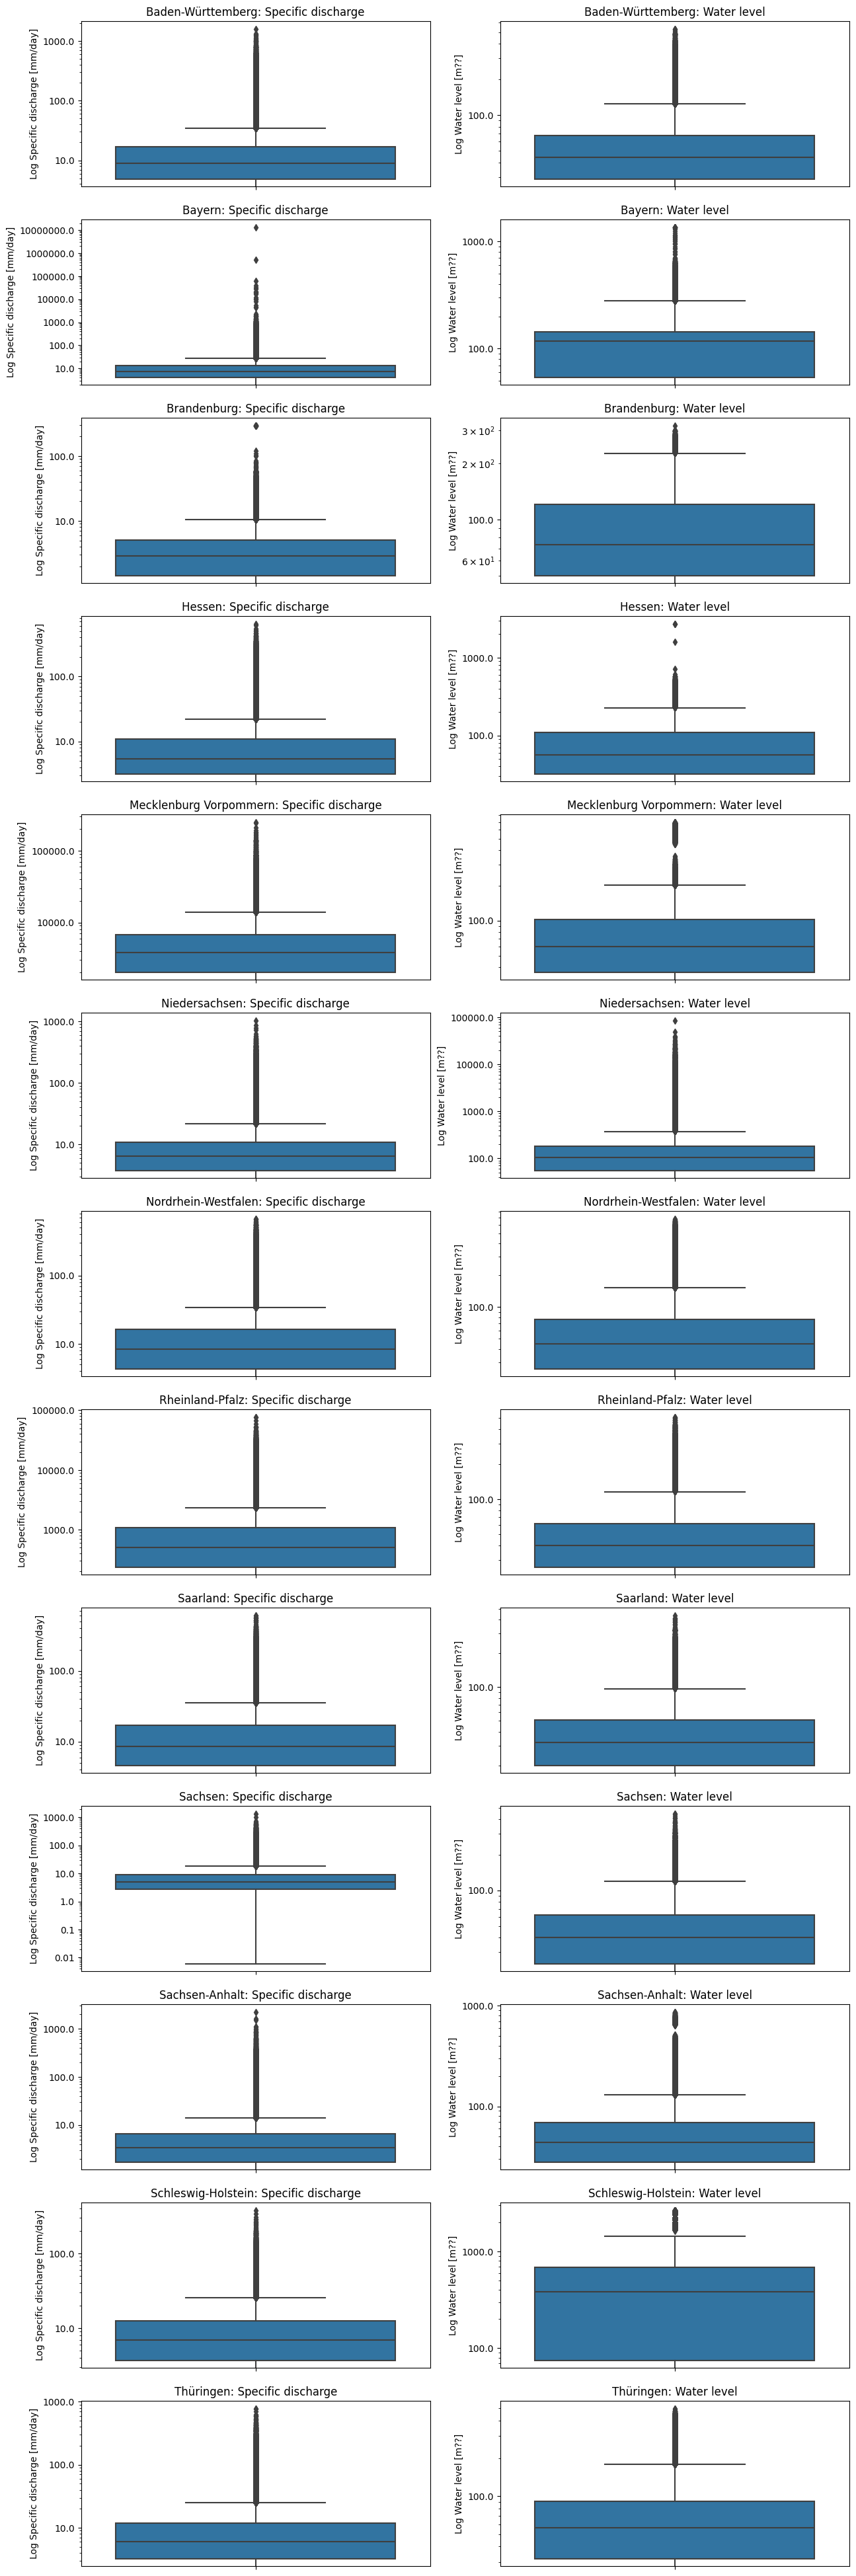

In [8]:
# get nuts_ids for Bundesländer
bls = sorted(metadata["federal_state"].unique())

# create subplots for each Bundesland
fig, axs = plt.subplots(len(bls), 2, figsize=(15, 50))

for row, bl in enumerate(bls):
    # camels_ids for Bundesland
    camels_ids = metadata[metadata["federal_state"] == bl]["camels_id"].values

    # df to store data of all stations in Bundesland
    df_bl = pd.DataFrame()

    for camels_id in camels_ids:
        # get CAMELS-DE data
        df = pd.read_csv(f"../output_data/camels_de/timeseries/CAMELS_DE_hydromet_timeseries_{camels_id}.csv")

        # add to df_bl
        df_bl = pd.concat([df_bl, df], axis=0)

    # make boxplot of discharge_spec (logarithmic)
    ax = axs[row, 0]

    sns.boxplot(data=df_bl, y="discharge_spec", ax=ax)
    ax.set_yscale("log")

    # add labels to plot
    ax.set_title(f"{bl}: Specific discharge")
    ax.set_ylabel("Log Specific discharge [mm/day]")
    ax.set_yticklabels(ax.get_yticks())

    # make boxplot of water_level
    ax = axs[row, 1]

    sns.boxplot(data=df_bl, y="water_level", ax=ax)
    ax.set_yscale("log")

    # add labels to plot
    ax.set_title(f"{bl}: Water level")
    ax.set_ylabel("Log Water level [m??]")
    ax.set_yticklabels(ax.get_yticks())

plt.show()

In [12]:
# save figure
fig.savefig("../hydromet_timeseries.png", dpi=300)